In [675]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from IPython.display import display, HTML

plt.rcParams["figure.figsize"] = (20, 10)

In [676]:
const_lr = lambda n, start: start
exp_lr = lambda n, start: start * np.exp(-0.01 * n)

# GD

In [677]:
def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])


def minibatch_grad(func, x, batch=30):
    return grad(func, x)


def cancel_condition(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-7


def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1, gradient=None):
    x = start

    points = list()
    grads = list()
    loss = list()
    points.append(x)
    for i in range(1, epoch):
        if gradient is None:
            grads.append(np.linalg.norm(minibatch_grad(f, x, batch)))
            loss.append(f(x))
            x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
            points.append(x)

            if np.linalg.norm(grad(f, x)) < 1e-7:
                break
        else:
            grads.append(np.linalg.norm(gradient(x)))
            loss.append(f(x))
            x = x - lr_strategy(i, lr) * np.array(gradient(x))
            points.append(x)

            if np.linalg.norm(gradient(x)) < 1e-7:
                break

    return [np.array(points), np.array(grads), np.array(loss)]


def gd(f, lr, start, lr_strategy=const_lr, epoch=20, gradient=None):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30, gradient=gradient)

# Adam

In [678]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1, gradient=None):
    x = start
    prev_grad = np.zeros(len(x))
    prev_v = np.zeros(len(x))

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):
        if gradient is None:
            gr = np.array(minibatch_grad(f, x, batch))
            grads.append(np.linalg.norm(gr))
            loss.append(f(x))
            g = b1 * prev_grad + (1 - b1) * gr
            v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
            x = x - lr_strategy(i, lr) * g / np.sqrt(v)
            prev_v = v
            prev_grad = g
            points.append(x)
            if np.linalg.norm(grad(minimizing_func, x)) < 1e-7:
                break
        else:
            gr = np.array(gradient(x))
            grads.append(np.linalg.norm(gr))
            loss.append(f(x))
            g = b1 * prev_grad + (1 - b1) * gr
            v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
            x = x - lr_strategy(i, lr) * g / np.sqrt(v)
            prev_v = v
            prev_grad = g
            points.append(x)
            if np.linalg.norm(gradient(x)) < 1e-7:
                break

    return np.array(points), np.array(grads), np.array(loss)

# Gauss-Newton

Используется для решения задачи Non Linear Least Squares. То есть $f(x) = \sum_{i=1}^{m} r_i(x)^2$, где $r_i$ какая то произвольная функция

Gradient:
$\displaystyle \frac{\partial f}{\partial x_j} = 2 \sum_{i=1}^{m} r_i(x) \cdot \frac{\partial r_i(x)}{\partial x_j}$ <br>
$\mathfrak{J} := \frac{\partial r_i(x)}{\partial x_j}$ <br>
$\nabla f = 2 \cdot \mathfrak{J}^T \cdot r$. <br>

Hessian:
$ H_{jk} = \frac{\partial^2 f}{\partial x_j \partial x_k} =2 \sum_{i=1}^{m}(\frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} + r_i \frac{\partial^2 r_i}{\partial x_j \partial x_k}) \approx 2 \sum_{i=1}^{m} \frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} = 2 \sum_{i=1}^{m} \mathfrak{J_{ij}} \dot \mathfrak{J_{ik}}$ <br>

$H = \nabla^2 f(x) \approx 2 \mathfrak{J}^T \mathfrak{J}$ <br>

В методе Ньютона: $x_{k+1} = x_k -  \alpha \cdot {\nabla^2 f(x_k)}^{-1} \cdot \nabla f(x_k)$

В методе Гаусса-Ньютона $x_{k+1} = x_k - \frac {\alpha} {2 \mathfrak{J}^T \mathfrak{J}} 2 \cdot \mathfrak{J}^T \cdot r = x_k - \frac {\alpha} { \mathfrak{J}^T \mathfrak{J}}  \cdot \mathfrak{J}^T \cdot r $ <br>

$ (\mathfrak{J}^T \mathfrak{J})^{-1}  \cdot \mathfrak{J}^T$ - pseudo inverse $\mathfrak{J}$

In [679]:
def minimizing_func2(b, idxs=range(100)):
    res = 0
    for i in idxs:
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res

In [680]:
def partial2(f, i, x, idxs):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad2(f, x, idx_of_term, idx_of_var):
    return partial2(f, idx_of_var, x, idx_of_term)

In [681]:
def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    pseudo_inverse = np.linalg.inv(JT @ JT.T) @ JT
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    return -pseudo_inverse @ np.array(rs).T


def newton(f, start, epoch=20):
    def grad_with_fixed_func(x):
        return grad(f, x)

    x = start
    points = list()
    grads = list()
    loss = list()
    points.append(start)
    for i in range(1, epoch):
        loss.append(f(x))
        grads.append(np.linalg.norm(grad(minimizing_func, x)))
        p = calcP(x)
        a = opt.line_search(f, grad_with_fixed_func, x, p)[0]
        x = x + a * np.array(p)
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points), grads, loss

## Dogleg (Powell)

Придумали, потому что метод Ньютона хорошо сходится в случае, если мы находимся в области, где функция близка в квадратичной. На отдалении же от этой точки функция далеко не обязательно описывается квадратичной моделью. Для этого придумали trust-region methods

$m_k(p) = f(x_k) + \nabla f(x_k)^T p + \frac{1}{2} \cdot p^T H p$ <br>


Хотим делать шаг с одной стороны находя минимум этой модели, но с другой стороны, не выходить за пределы нашего доверительного региона, так как за его пределами приближение может работать довольно-таки плохо <br>

То есть мы хотим найти $\displaystyle \min_{\|p\| \leq \Delta_k} m(p)$, где $\Delta_k$ - радиус доверительного региона. <br>

$\displaystyle p^U = - \frac{\nabla f^T \nabla f}{\nabla f^T H \nabla f} \nabla f$ - минимум вдоль направления градиента <br>

$p^H$ = $\displaystyle - \frac{\nabla f}{H}$ - минимум квадратичной модели <br>

Если вся собачья нога находится внутри доверительного региона, то мы шагаем туда. Если нет, то хотим найти пересечение ломанной с нашей сферой. <br>

Если $p^U$ находится на расстоянии больше чем наш радиус, то находим их пересечение. Если меньше, то пересекаем отрезок между $p^U$ и $p^H$ со сферой <br>

$\displaystyle \rho_k = \frac{f(x_k) - f(x_k + p_k)}{m_k(0) - m_k(p_k)}$ <br>

Если $\rho_k$ маленькое (возможно отрицательное), то модель плохо соответствует целевой функции, и доверительный регион нужно уменьшить<br>
Если $\rho_k$ большое, то модель очень хорошо описывает функции, и доверительный регион можно увеличить <br>



In [682]:
def get_rho(f, x, p, calc_hessian, local_grad):
    fx = f(x) - f(x + p)
    mk = m(f, calc_hessian, x, np.zeros(len(x)), local_grad) - m(f, calc_hessian, x, p, local_grad)
    return fx / mk


def m(f, calc_hessian, x, p, local_grad):
    return f(x) + np.transpose(local_grad(f, x)) @ p + 1 / 2 * np.transpose(p) @ calc_hessian(x) @ p


def calc_hessian_for_lsm(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    return 2 * JT @ JT.T


def calc_p(f, calc_hessian, x, delta, local_grad):
    H = calc_hessian(x)
    gr = local_grad(f, x)

    pH = -np.linalg.inv(H) @ gr

    if np.linalg.norm(pH) <= delta:
        return pH

    pU = - (np.dot(gr, gr) / np.dot(gr, np.dot(H, gr))) * gr

    if np.linalg.norm(pU) >= delta:
        return delta * pU / np.linalg.norm(pU)

    A = pU
    B = pH - pU

    D4 = (A.T @ B) * (A.T @ B) - (B.T @ B) * (A.T @ A - delta * delta)

    T = (-A.T @ B + np.sqrt(D4)) / (B.T @ B)

    return A + T * B


def dogleg(f, start, calc_hessian, delta=1, nu=1 / 4, epoch=20, delta_max=100, gradient=None):
    x = start

    if gradient is not None:
        def local_grad(f, x):
            return gradient(x)
    else:
        def local_grad(f, x):
            return grad(f, x)

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):

        grads.append(np.linalg.norm(local_grad(f, x)))
        loss.append(f(x))

        p = calc_p(f, calc_hessian, x, delta, local_grad)

        ro = get_rho(f, x, p, calc_hessian, local_grad)

        if ro < 1 / 4:
            delta = 1 / 4 * delta
        elif ro > 3 / 4 and np.linalg.norm(ro) == delta:
            delta = min(2 * delta, delta_max)
        else:
            delta = delta

        if ro > nu:
            x = x + p
        else:
            x = x

        points.append(x)

        if np.linalg.norm(local_grad(f, x)) < 1e-7:
            break

    return np.array(points), np.array(grads), np.array(loss)

# BFGS


$B$ - гессиан

Из метода Ньютона $p_k = -B_k^{-1} \nabla f_k$

Хотим чтобы у нас по нашей модели был правильный градиент на последнем шаге и предпоследнем. То есть делаем шаг и проверяем чему с точки зрения текущего гессиана должен был равен прошлый шаг.

$\nabla m_{k+1} (-\alpha_k p_k) = \nabla f_{k+1} - \alpha_k \beta_{k+1}p_k = \nabla f_k$ <br>

$B_{k+1} \alpha_k p_k = \nabla f_{k+1} - \nabla f_k$ <br>

$s_k := \alpha_k p_k = x_{k+1} - x_k$ <br>

$y_k := \nabla f_{k+1} - \nabla f_k$ <br>

$H_{k+1} y_k = s_k$ <br>
$H_{k+1} = argmin(|H-H_k|)$ по H, при условии, что H положительно определенная и $H y_k = s_k$ и $s_{k}^T \cdot y_k > 0$, чтобы приближение гессиана было положительно определенным. Чтобы оно соблюдалось, надо делать шаги с условиями Вольфе. <br> <br>

$H_{k+1} = (I - \rho_k s_k y_k^T) H_k (I-\rho_k y_k s_k^T) + \rho_k s_k s_k^T$ , где $\rho_k = \frac {1} {y_k^T s_k}$ <br>

Тогда $p_k = -H_k \nabla f_k$<br>
$p_k = -H_k \cdot \nabla f$  - точка, в направлении которой будем осуществлять поиск<br>

$x_{k+1} = x_k + \alpha_k p_k$, где $\alpha_k$ ищется с помощью одномерного поиска с выполнением условий Вольфе<br>



In [683]:
def gradient_func1(x):
    return np.array(minibatch_grad(minimizing_func, x))

def bfgs(f, grad_with_fixed_func, start, epoch):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(x)

    I = np.eye(len(x))
    H = I

    gr = grad(f, x)
    loss.append(f(x))

    grads.append(np.linalg.norm(gr))
    for i in range(1, epoch):

        p = - H @ gr

        coef = opt.line_search(f, grad_with_fixed_func, x, p)[0]

        new_x = x + coef * p

        s = new_x - x
        x = new_x
        new_grad = grad(f, x)
        grads.append(np.linalg.norm(new_grad))
        loss.append(f(x))
        points.append(x)
        y = new_grad - gr

        if np.linalg.norm(grad(f, x)) < 1e-6:
            break

        gr = new_grad

        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y, (len(x), 1))
        s = np.reshape(s, (len(x), 1))

        ro = 1.0 / (y.T @ s)
        H = (I - ro * s @ y.T) @ H @ (I - ro * y @ s.T) + ro * s @ s.T

    return [np.array(points), np.array(grads), np.array(loss)]

#### $f(x) = \frac{\exp^{-1 \cdot x}}{2+3 \cdot x}$

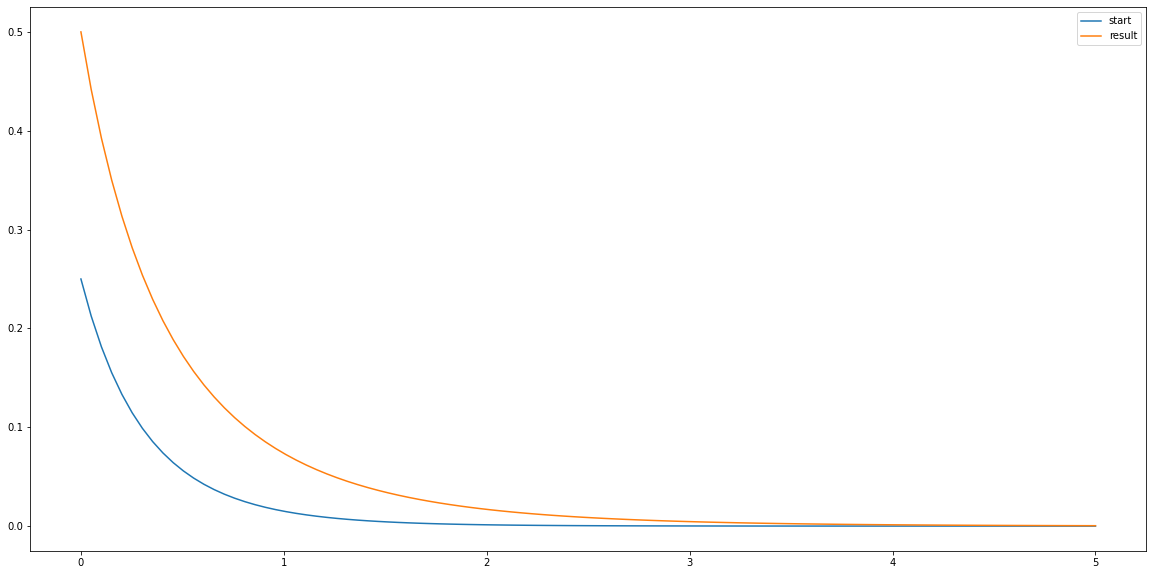

In [684]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

start_point = [2, 4, 5]

exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

plt.plot(xs, func(xs, *start_point), label='start')
plt.plot(xs, ys, label='result')

plt.legend()

,Method,Number of iterations,Found,Expected
0,Gauss-Newton,24,"[0.9999993364699511, 1.9999999521643463, 3.000...","[1, 2, 3]"
1,GD,24261,"[0.9999849797706837, 1.9999965754579587, 3.000...","[1, 2, 3]"
2,Adam,825,"[1.0000000907150144, 2.000000091328349, 3.0000...","[1, 2, 3]"
3,Dogleg,1000,"[0.9938515295154404, 1.9985928093851508, 3.029...","[1, 2, 3]"
4,BFGS,21,"[0.9999958973002173, 2.0000005862026002, 3.000...","[1, 2, 3]"


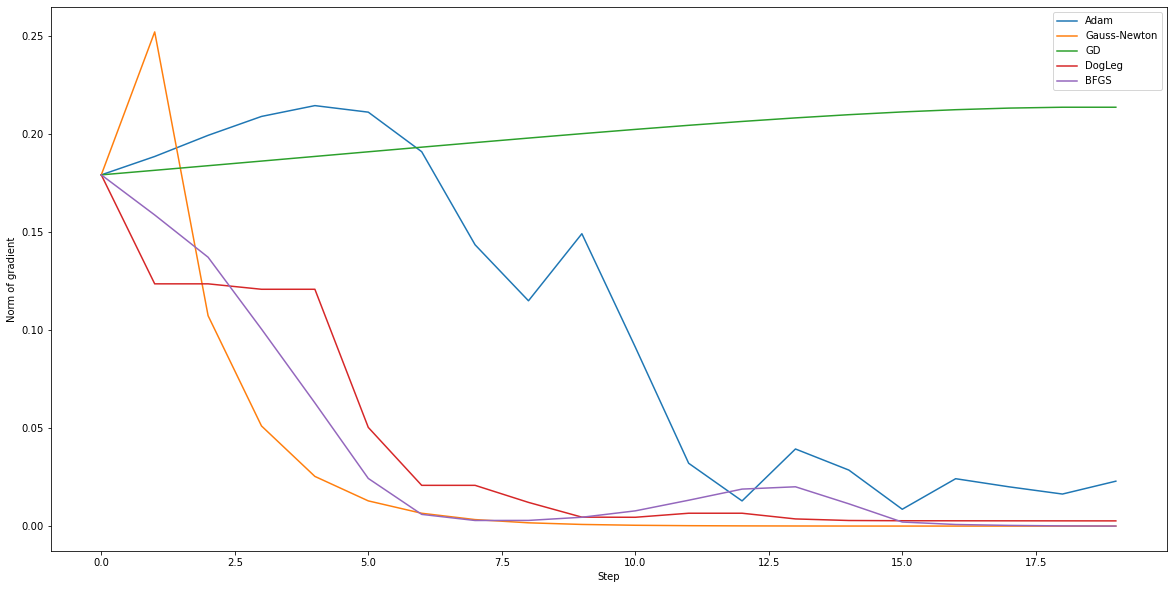

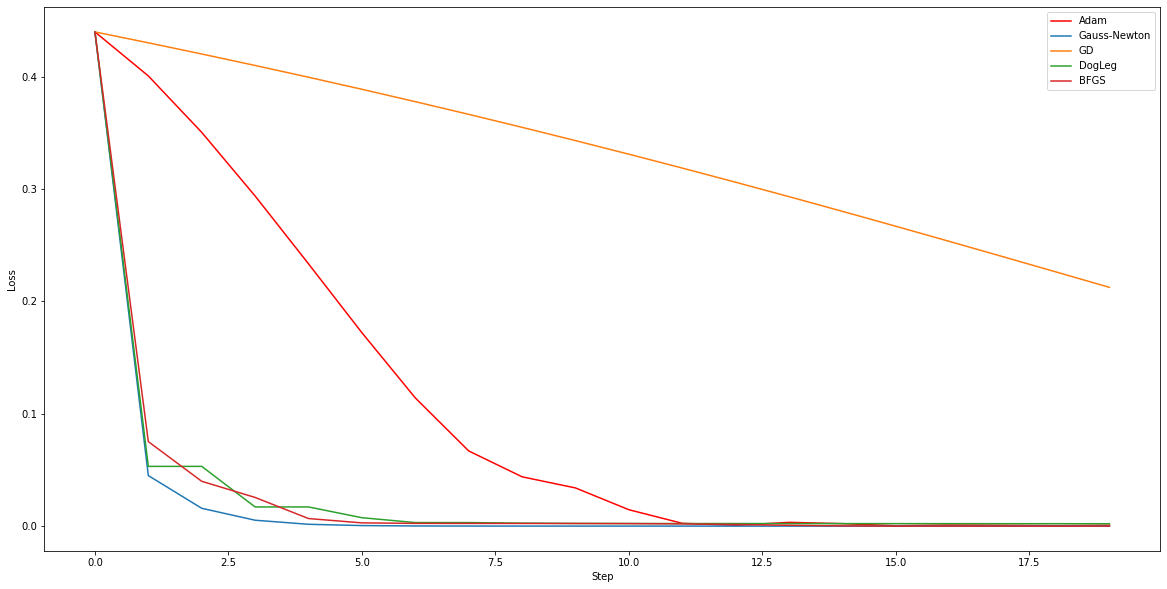

In [685]:
gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point,
                                          lr_strategy=exp_lr, epoch=50000, batch=30)
newton_points, newton_grads, newton_loss = newton(minimizing_func2, start=start_point, epoch=2000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, calc_hessian_for_lsm, delta=2, epoch=1000)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)

df = pd.DataFrame(data={
    "Method": ['Gauss-Newton', 'GD', 'Adam', 'Dogleg', 'BFGS'],
    "Number of iterations": [len(newton_points), len(gd_points), len(adam_points), len(dogleg_points),
                             len(bfgs_points)],
    "Found": [newton_points[-1], gd_points[-1], adam_points[-1], dogleg_points[-1], bfgs_points[-1]],
    'Expected': [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]
})
display(df)

size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_grads[:size], label='Adam')
plt.plot(ss, newton_grads[:size], label='Gauss-Newton')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

plt.plot(ss, adam_loss[:size], 'r', label='Adam')
plt.plot(ss, newton_loss[:size], label='Gauss-Newton')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

,Method,Number of iterations,Found,Expected
0,Gauss-Newton,24,"[0.9999995370906352, 2.000000071740815, 3.0000...","[3, 6, 5]"
1,GD,24080,"[0.9999849818109496, 1.9999965759231337, 3.000...","[3, 6, 5]"
2,Adam,644,"[0.9999998931142954, 1.9999999155033694, 3.000...","[3, 6, 5]"
3,Dogleg,999,"[0.9946945125548927, 1.9988491809136852, 3.025...","[3, 6, 5]"
4,BFGS,21,"[0.9999999516318911, 2.0000002243960986, 3.000...","[3, 6, 5]"


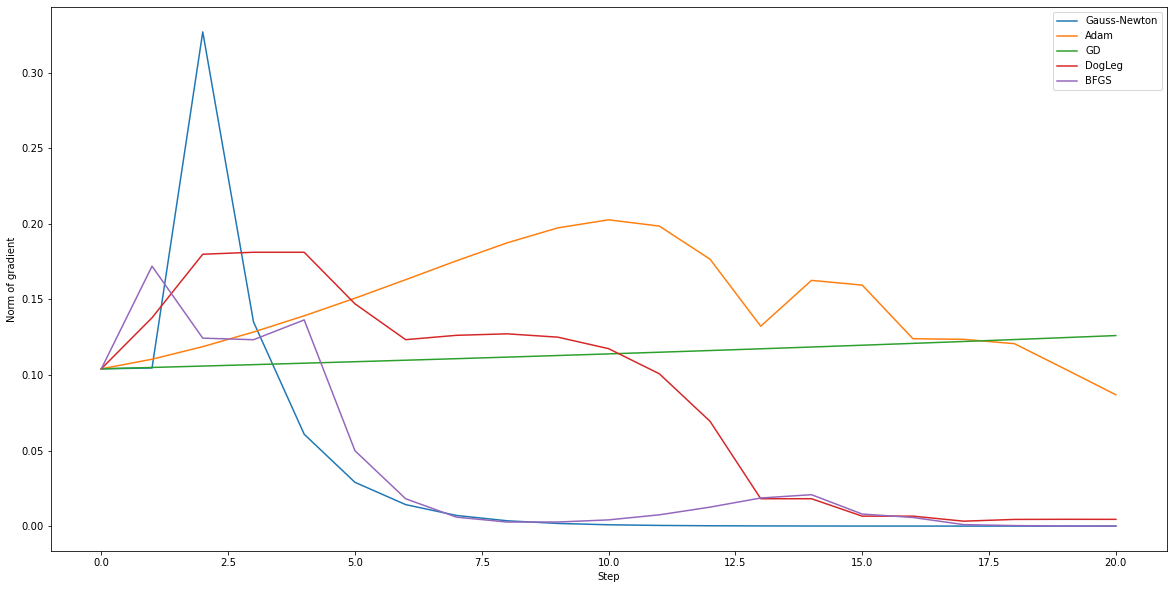

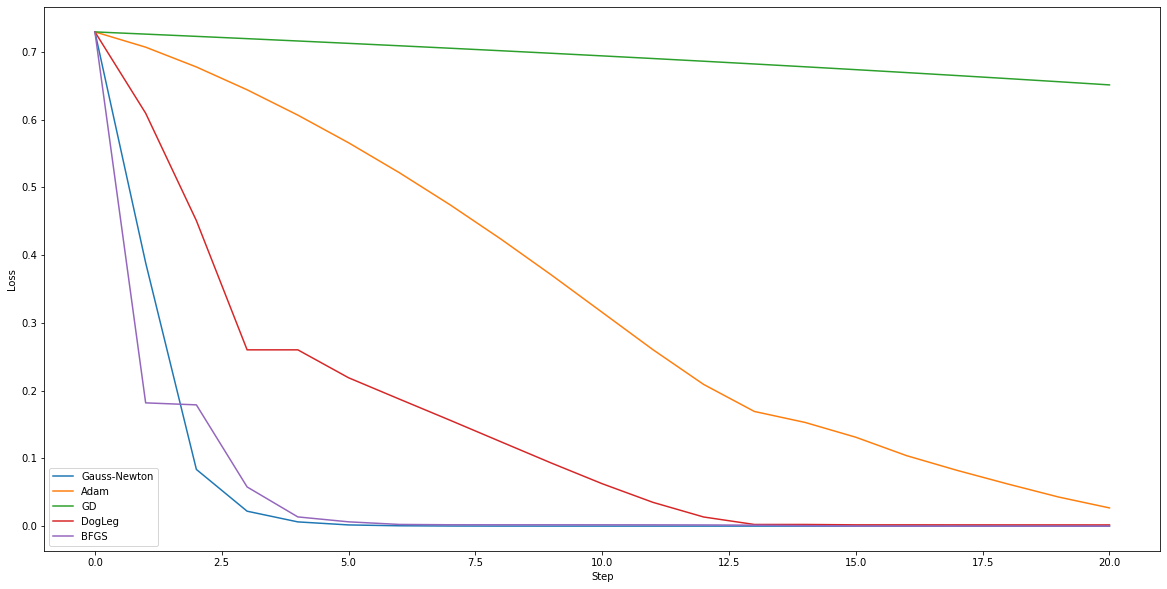

In [686]:
start_point = [3, 6, 5]

newton_points, newton_grads, newton_loss = newton(minimizing_func2, start=start_point, epoch=2000)
gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point,
                                          lr_strategy=exp_lr, epoch=50000, batch=30)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, calc_hessian_for_lsm, delta=1, epoch=1000)

df = pd.DataFrame(data={
    "Method": ['Gauss-Newton', 'GD', 'Adam', 'Dogleg', 'BFGS'],
    "Number of iterations": [len(newton_points) - 1, len(gd_points) - 1, len(adam_points) - 1, len(dogleg_points) - 1,
                             len(bfgs_points) - 1],
    "Found": [newton_points[-1], gd_points[-1], adam_points[-1], dogleg_points[-1], bfgs_points[-1]],
    'Expected': [[3, 6, 5], [3, 6, 5], [3, 6, 5], [3, 6, 5], [3, 6, 5]]
})

display(df)

size = min(len(gd_points), len(newton_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, newton_grads[:size], label='Gauss-Newton')
plt.plot(ss, adam_grads[:size], label='Adam')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

size = min(len(gd_points), len(newton_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, newton_loss[:size], label='Gauss-Newton')
plt.plot(ss, adam_loss[:size], label='Adam')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

#### $f(x) = x^2 + y^2$

,Method,Number of iterations,Found,Expected
0,GD,20,"[-2.199023255552003e-08, 3.2985348833280056e-08]","[0, 0]"
1,Adam,24,"[-7.470372038026217e-09, 3.341492380955499e-08]","[0, 0]"
2,Dogleg,2,"[3.19211324040225e-12, -3.862477004901166e-11]","[0, 0]"
3,BFGS,1,"[4.099284689473848e-09, 2.7328566076789684e-09]","[0, 0]"


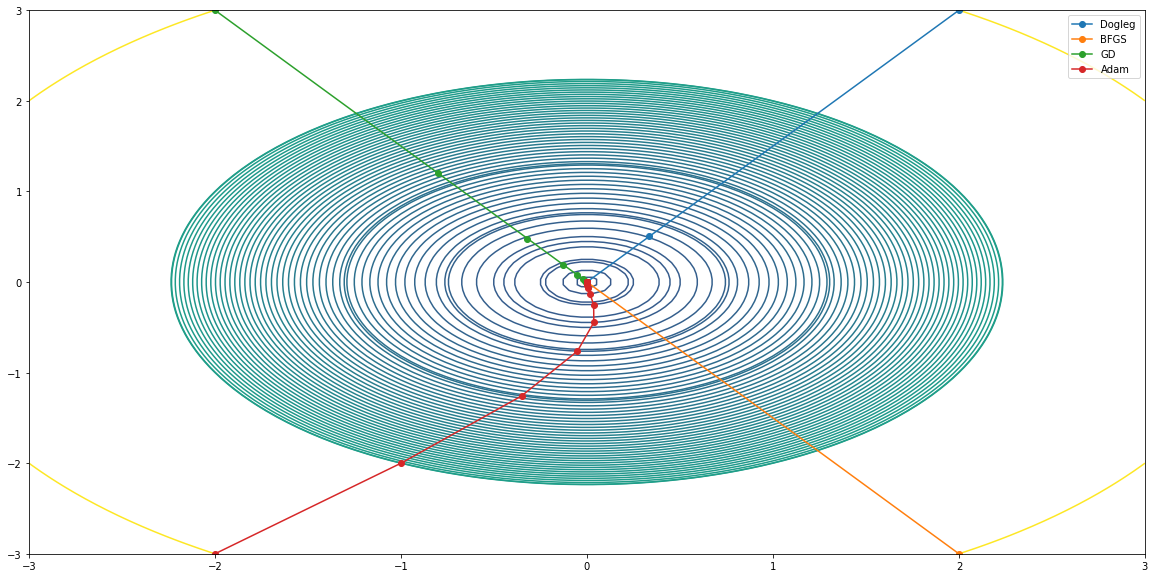

In [687]:
quad = lambda x: x[0] ** 2 + x[1] ** 2
quad_grad = lambda x: np.array([2 * x[0], 2 * x[1]])
quad_hess = lambda x: np.array(([2, 0], [0, 2]))

gd_points, gd_grads, gd_loss = gd(quad, 0.3, start=[-2, 3], lr_strategy=const_lr, epoch=50000, gradient=quad_grad)
adam_points, adam_grads, adam_loss = adam(quad, b1=0.2, b2=0.9, lr=0.4, start=[-2, -3], lr_strategy=exp_lr, epoch=50000,
                                          batch=30, gradient=quad_grad)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(quad, [2, 3], quad_hess, delta=3, epoch=1000)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(quad, quad_grad, [2, -3], epoch=1000)

df = pd.DataFrame(data={
    "Method": ['GD', 'Adam', 'Dogleg', 'BFGS'],
    "Number of iterations": [len(gd_points) - 1, len(adam_points) - 1, len(dogleg_points) - 1, len(bfgs_points) - 1],
    "Found": [gd_points[-1], adam_points[-1], dogleg_points[-1], bfgs_points[-1]],
    'Expected': [[0, 0], [0, 0], [0, 0], [0, 0]]
})

display(df)

t = np.linspace(-3, 3, 100)
X = np.meshgrid(t, t)

plt.contour(X[0], X[1], quad(X), levels=sorted([quad(p) for p in adam_points] + list(np.linspace(-5, 5, 100))))

plt.plot(dogleg_points[:, 0], dogleg_points[:, 1], 'o-', label='Dogleg')

plt.plot(bfgs_points[:, 0], bfgs_points[:, 1], 'o-', label='BFGS')
plt.plot(gd_points[:, 0], gd_points[:, 1], 'o-', label='GD')
plt.plot(adam_points[:, 0], adam_points[:, 1], 'o-', label='Adam')

plt.legend()

#### $f(x, y) = (1-x)^2 + 100 (y-x^2)^2$

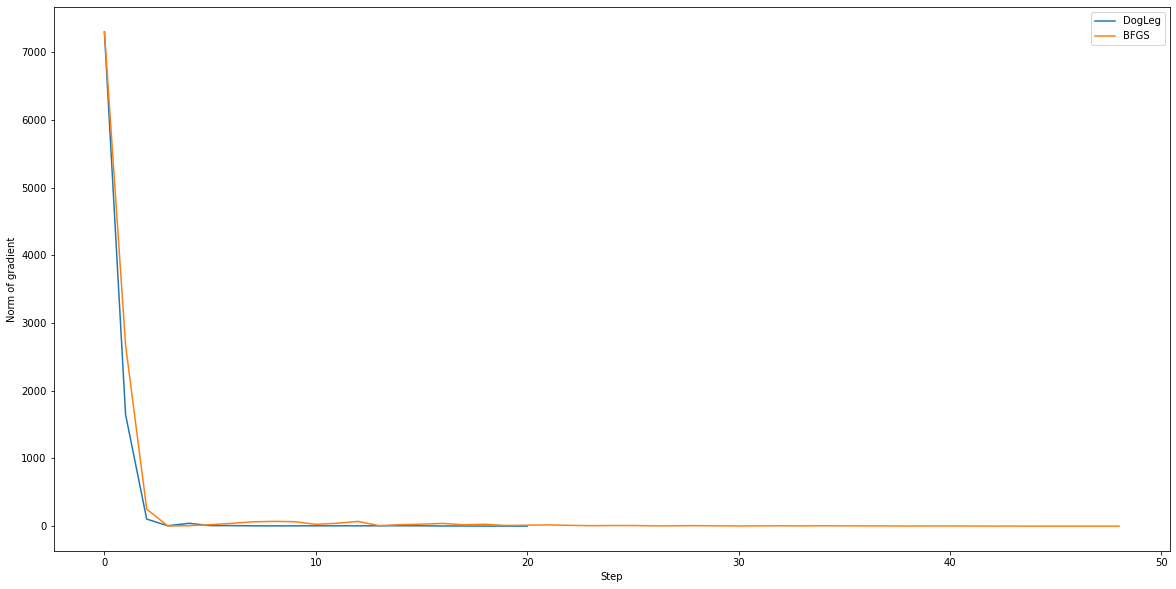

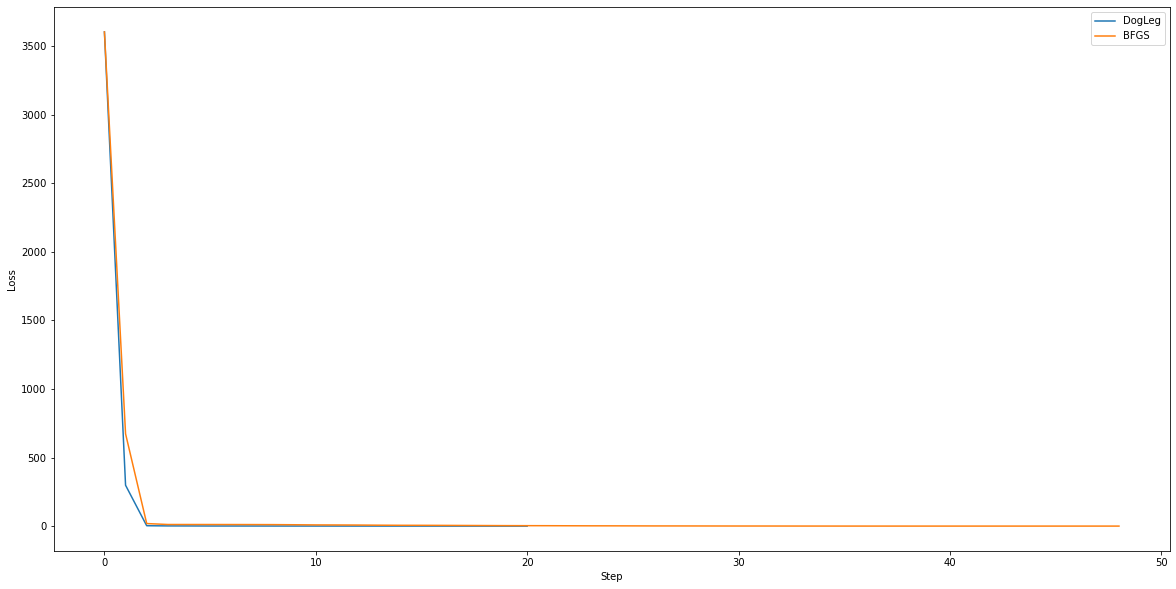

In [688]:
rosenbrok = lambda x: (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2
rosenbrok_grad = lambda x: np.array([2 * (200 * x[0] ** 3 - 200 * x[0] * x[1] + x[0] - 1), 200 * (x[1] - x[0] ** 2)])
rosenbrok_hess = lambda x: np.array(
    ([-400 * (x[1] - x[0] ** 2) + 800 * x[0] ** 2 + 2, -400 * x[0]], [-400 * x[0], 200]))

start_point = [3, 3]

bfgs_points, bfgs_grads, bfgs_loss = bfgs(rosenbrok, rosenbrok_grad, start=start_point, epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(rosenbrok, start_point, rosenbrok_hess, delta=1, epoch=1000)

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(range(len(dogleg_grads)), dogleg_grads, label='DogLeg')
plt.plot(range(len(bfgs_grads)), bfgs_grads, label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

plt.plot(range(len(dogleg_loss)), dogleg_loss, label='DogLeg')
plt.plot(range(len(bfgs_loss)), bfgs_loss, label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()